<h2> Neural Networks Models for Binary Classifcation Data Sets </h2>

In [1]:
import torch
import os
import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [2]:
print(f'GPU is recognized : {torch.cuda.is_available()}')
print(torch.cuda.device(torch.cuda.current_device()))
print(f'Number of GPU : {torch.cuda.device_count()}')
print(f'GPU Name : {torch.cuda.get_device_name(0)}')

GPU is recognized : True
Number of GPU : 1
GPU Name : NVIDIA GeForce GTX 1050


In [3]:
#file paths
#file_path_breast_cancer = 
breast_cancer_file_path = os.path.join(os.getcwd(),"datasets","bi-class","breast-cancer.npz")
diabetes_file_path = os.path.join(os.getcwd(),"datasets","bi-class","diabetes.npz")
iris_file_path = os.path.join(os.getcwd(),"datasets","bi-class","iris.npz")
wine_file_path = os.path.join(os.getcwd(),"datasets","bi-class","wine.npz")

In [4]:
breast_cancer_data = np.load(breast_cancer_file_path)
diabetes_data = np.load(diabetes_file_path)
iris_data = np.load(iris_file_path)
wine_data = np.load(wine_file_path)

In [5]:
def output_train_test(npzfile):
    data_dict = {}
    for file in npzfile.files:
        data_dict[file] = npzfile[file]
    return data_dict

In [6]:
breast_cancer_dict = output_train_test(breast_cancer_data)
diabetes_dict = output_train_test(diabetes_data)
iris_dict = output_train_test(iris_data)
wine_dict = output_train_test(wine_data)

In [7]:
#number of attributes in each dataset
print(f'Breast Cancer Dataset : {breast_cancer_dict["train_X"].shape[1]}')
print(f'Diabetes Dataset : {diabetes_dict["train_X"].shape[1]}')
print(f'Iris Dataset : {iris_dict["train_X"].shape[1]}')
print(f'Wine Dataset : {wine_dict["train_X"].shape[1]}')

Breast Cancer Dataset : 10
Diabetes Dataset : 8
Iris Dataset : 4
Wine Dataset : 13


In [8]:
#breast cancer data
train_data_breast_cancer = breast_cancer_dict["train_X"]
train_labels_breast_cancer = breast_cancer_dict["train_Y"]
test_data_breast_cancer = breast_cancer_dict["test_X"]
test_labels_breast_cancer = breast_cancer_dict["test_Y"]
#diabetes data
train_data_diabetes = diabetes_dict["train_X"]
train_labels_diabetes = diabetes_dict["train_Y"]
test_data_diabetes = diabetes_dict["test_X"]
test_labels_diabetes = diabetes_dict["test_Y"]
#iris data
train_data_iris = iris_dict["train_X"]
train_labels_iris = iris_dict["train_Y"]
test_data_iris = iris_dict["test_X"]
test_labels_iris = iris_dict["test_Y"]
#wine data
train_data_wine = wine_dict["train_X"]
train_labels_wine = wine_dict["train_Y"]
test_data_wine = wine_dict["test_X"]
test_labels_wine = wine_dict["test_Y"]

In [9]:
#normalization of training data
#breast cancer data
scaler_breast_cancer = StandardScaler()
scaler_breast_cancer.fit(train_data_breast_cancer)
train_data_breast_cancer = scaler_breast_cancer.transform(train_data_breast_cancer)

#diabetes data
scaler_diabetes = StandardScaler()
scaler_diabetes.fit(train_data_diabetes)
train_data_diabetes = scaler_diabetes.transform(train_data_diabetes)

#iris data
scaler_iris = StandardScaler()
scaler_iris.fit(train_data_iris)
train_data_iris = scaler_iris.transform(train_data_iris)

#wine data
scaler_wine = StandardScaler()
scaler_wine.fit(train_data_wine)
train_data_wine = scaler_wine.transform(train_data_wine)

In [10]:
#The data types for the tensors in the dataloaders is Double
#Pytorch expects Floats for X and Long for Y
#So when we forward prop and call model(X) we should call model(X.float())
#When calculating loss, loss_fn(y_pred,y.long()
#for batch,(X,y) in enumerate(breast_cancer_train_dataloader):
#    print(X.type())
#    print(y.unsqueeze(0).type())
#    #print(y.unsqueeze(0).shape)
#    break

In [31]:
class NeuralNetwork(nn.Module):
    def __init__(self,input_shape,number_of_hidden_units):
        super(NeuralNetwork,self).__init__()
        self.linear_stack = nn.Sequential(
            #single hidden layer
            nn.Linear(in_features=input_shape,out_features=number_of_hidden_units, bias=True),
            #using the Relu Activation function
            nn.ReLU(),
            #output layer
            nn.Linear(in_features=number_of_hidden_units,out_features=1, bias=True),
            nn.Sigmoid()
        )

    def forward(self,x):
        forward_prop = self.linear_stack(x)
        return forward_prop

def train(dataloader, model, loss_fn, optimizer,device):
    #lets the model know that it is in training mode 
    #this will keep layers like Batch Norm. layers in train mode
    model.train()
    for batch,(X,Y) in enumerate(dataloader):
        #Note that as batch_size and batch_sample were set to None, 
        #this will send one instance at a time during training
        #sends the X instance to the GPU, as I'm using GPU here
        X = X.to(device)
        Y = Y.to(device)
        #predict
        pred = model(X.float())
        #calculate loss
        loss = loss_fn(pred,Y.unsqueeze(0).float())
        #set all gradients from previous runs to zero
        optimizer.zero_grad()
        #back propogate the loss
        loss.backward()
        #update parameters
        optimizer.step()    

        #printing the current loss, every ten instances
        #if batch%50 == 0:
        #    print(f'Training Instance {batch}, Loss : {loss.item()}')

def validate(dataloader,model,loss_fn,device,test = False):
    model.eval()
    testing_loss = 0
    correct = 0
    if test == True:
        y_pred_scores = list()
        y_pred_list = list()
    #torch.no_grad disables gradient calculation and makes sure not 
    #to do backpropagation
    validate_inst_count = 0
    with torch.no_grad():
        for batch,(X,Y) in enumerate(dataloader):
            X = X.to(device)
            Y = Y.to(device)
            y_pred = model(X.float())
            loss = loss_fn(y_pred,Y.unsqueeze(0).float())
            validate_inst_count += 1
            testing_loss += loss.item()
            #y_pred.argmax(1) == y will return True or False
            #as it is being tested one instance at a time,
            #it will be one True or False
            #.astype(torch.float) makes it to a 1 or 0
            #As its one instance at a time, no need to sum
            #output y_pred is of shape [1], y is of shape[]
            correct += (y_pred.round() == Y.unsqueeze(0)).type(torch.float).item()
            if test == True:
                y_pred_scores.append(y_pred)
                y_pred_list.append(y_pred.round())
            #print(y_pred.shape)
            #print(y.unsqueeze(0).shape)
    avg_loss = testing_loss/validate_inst_count
    avg_accuracy = correct/validate_inst_count
    #print(f'Testing Accuracy : {avg_accuracy},Correct:{correct},total:{validate_inst_count}, Loss : {avg_loss}')
    if test == True: 
        return avg_accuracy,avg_loss,y_pred_scores,y_pred_list
    else:
        return avg_accuracy,avg_loss

In [32]:
#function to start train and test

def train_and_validate(train_dataloader, validate_dataloader, model,loss_fn,learning_rate,device,epoch_no,test = False):
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)
    #train over multiple epochs
    accuracy_across_all_epochs = 0
    loss_across_all_epochs = 0
    for i in range(epoch_no):
        train(train_dataloader,model,loss_fn,optimizer,device)
        #avg_accuracy,avg_loss = validate(validate_dataloader,model,loss_fn,device)
        #accuracy_across_all_epochs += avg_accuracy
        #loss_across_all_epochs += avg_loss
    if test == False and validate_dataloader != None:
        avg_accuracy,avg_loss = validate(validate_dataloader,model,loss_fn,device)
        #reports the accuracy and loss on the validation set
        #return model,accuracy_across_all_epochs/epoch_no,loss_across_all_epochs/epoch_no
        return model,avg_accuracy,avg_loss
    else:
        return model

In [13]:
""" build the Neural Network Class
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model_breast_cancer = NeuralNetwork(input_shape=X_train_breast_cancer.shape[1],number_of_hidden_units=5)
loss_fn = nn.BCELoss()
learning_rate = 1e-3
model_breast_cancer = train_and_validate(breast_cancer_train_dataloader,breast_cancer_valid_dataloader,model_breast_cancer,loss_fn,learning_rate,device,5) """

' build the Neural Network Class\nif torch.cuda.is_available():\n    device = "cuda"\nelse:\n    device = "cpu"\n\nmodel_breast_cancer = NeuralNetwork(input_shape=X_train_breast_cancer.shape[1],number_of_hidden_units=5)\nloss_fn = nn.BCELoss()\nlearning_rate = 1e-3\nmodel_breast_cancer = train_and_validate(breast_cancer_train_dataloader,breast_cancer_valid_dataloader,model_breast_cancer,loss_fn,learning_rate,device,5) '

In [12]:
from itertools import product
learning_rate_list = [1e-4,1e-3,1e-2,0.1]
hidden_units = [1,2,3,4,5,6,7,8,9,10]

combinations = list(product([i for i,j in enumerate(learning_rate_list)], [i for i,j in enumerate(hidden_units)]))
parameter_list = list()

for combination in combinations:
    parameter_list.append([learning_rate_list[combination[0]],hidden_units[combination[1]]])

In [13]:
#Breast Cancer Dataset
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
result_dict_breast_cancer = dict()
randstate = 1
#go through the parameter combinations, returning the average accuracy and loss 
#on the validation set for each parameter combination
for parameter_set in parameter_list:
    learning_rate = parameter_set[0]
    hidden_units = parameter_set[1]
    epoch_num = 10
    #number of folds for cross validation
    k = 5
    #kfold splitter
    ksplitter = KFold(n_splits = 5, shuffle=True,random_state=42)

    model_score = 0
    model_loss = 0
    #k Fold cross validation
    for train_idx,valid_idx in ksplitter.split(train_data_breast_cancer):
        model_breast_cancer = NeuralNetwork(input_shape=train_data_breast_cancer.shape[1],number_of_hidden_units=hidden_units)
        loss_fn = nn.BCELoss()
        X_train,y_train = train_data_breast_cancer[train_idx],train_labels_breast_cancer[train_idx]
        X_valid,y_valid = train_data_breast_cancer[valid_idx],train_labels_breast_cancer[valid_idx]
        #create pytorch dataset
        ds_train = TensorDataset(torch.tensor(X_train),torch.tensor(y_train))
        train_dataloader = DataLoader(ds_train,batch_sampler=None,batch_size=None)
        #breast cancer
        ds_valid = TensorDataset(torch.tensor(X_valid),torch.tensor(y_valid))
        valid_dataloader = DataLoader(ds_valid,batch_sampler=None,batch_size=None)
        model_breast_cancer,accuracy,loss = train_and_validate(train_dataloader,valid_dataloader,model_breast_cancer,loss_fn,learning_rate,device,epoch_num)
        model_score += accuracy
        model_loss += loss
    
    result_dict_breast_cancer[f'learning_rate : {learning_rate}, hidden_units = {hidden_units}'] = [model_score/k,model_loss/k]

In [18]:
results_key = list()
accuracy_values_breast_cancer = list()
loss_values_breast_cancer = list()

for i in result_dict_breast_cancer:
    results_key.append(i)
    accuracy_values_breast_cancer.append(result_dict_breast_cancer[i][0])
    loss_values_breast_cancer.append(result_dict_breast_cancer[i][1])


C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

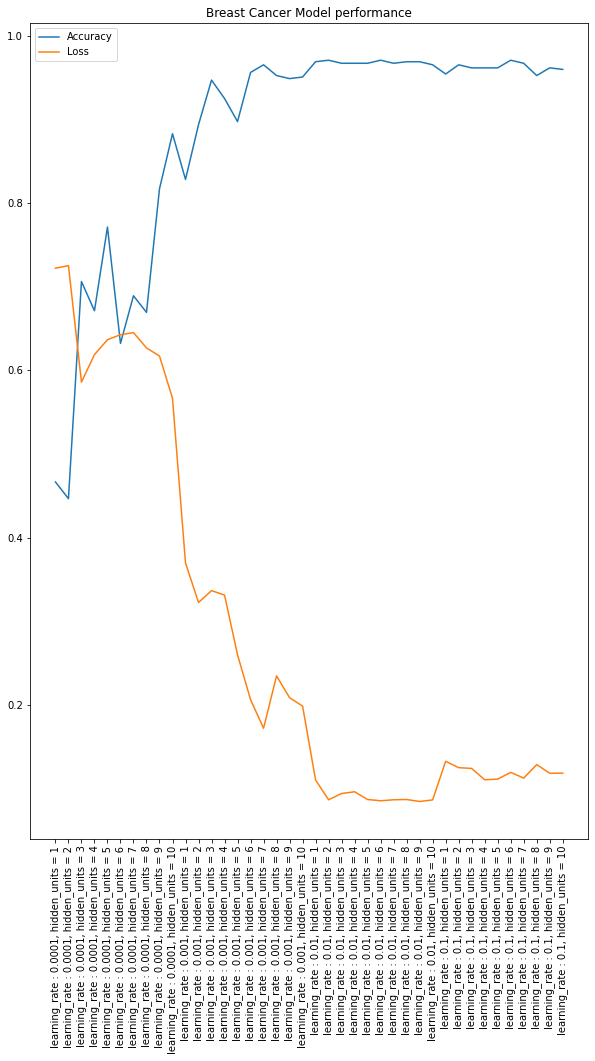

In [19]:
fig,ax = plt.subplots(1,1,figsize = (10,15))

sns.lineplot(results_key,accuracy_values_breast_cancer,ax = ax,palette = 'b', label = 'Accuracy')
sns.lineplot(results_key,loss_values_breast_cancer,ax = ax, palette=['r'],label = "Loss")
ax.set_title('Breast Cancer Model performance')
ax.legend()
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.xticks(rotation = 90)

In [21]:
#combining all the results together for breast cancer
overall_results_breast_cancer = zip(results_key,accuracy_values_breast_cancer,loss_values_breast_cancer)
best_model_breast_cancer = sorted(overall_results_breast_cancer,key = lambda x : x[0], reverse=True)
best_model_breast_cancer[0]

('learning_rate : 0.1, hidden_units = 9',
 0.9616680567139282,
 0.11846093341630419)

In [24]:
#Training the best model on the entire training data set and testing on test set with the best parameters found in cross validation
model_breast_cancer_final = NeuralNetwork(input_shape=train_data_breast_cancer.shape[1],number_of_hidden_units=9)
loss_fn = nn.BCELoss()
ds_train = TensorDataset(torch.tensor(train_data_breast_cancer),torch.tensor(train_labels_breast_cancer))
train_dataloader = DataLoader(ds_train,batch_sampler=None,batch_size=None)
#as we dont do any validation, the validation parameter is None here
model_breast_cancer_final = train_and_validate(train_dataloader,None,model_breast_cancer_final,loss_fn,0.1,device,epoch_num,test = True)

#breast cancer
test_data_breast_cancer_scaled = scaler_breast_cancer.transform(test_data_breast_cancer)
ds_test = TensorDataset(torch.tensor(test_data_breast_cancer_scaled),torch.tensor(test_labels_breast_cancer))
test_dataloader = DataLoader(ds_test,batch_sampler=None,batch_size=None)

loss_fn = nn.BCELoss()
accuracy,loss,y_test_scores,y_predicted = validate(test_dataloader,model_breast_cancer_final,loss_fn,device,test = True)


In [25]:
print(f"Test Accuracy :{accuracy}, Test Loss {loss}")

Test Accuracy :0.9705882352941176, Test Loss 0.0781001705025029


In [26]:
y_test_scores_array = np.array([i.item() for i in y_test_scores])

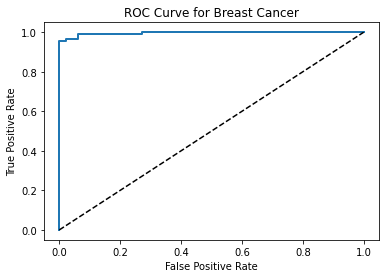

In [27]:
#plot ROC curve
def plot_roc_curve(fpr, tpr, label=None):
 plt.plot(fpr, tpr, linewidth=2, label=label)
 plt.plot([0, 1], [0, 1], 'k--') 
 plt.ylabel('True Positive Rate')
 plt.xlabel('False Positive Rate')
 plt.title('ROC Curve for Breast Cancer')

fpr,tpr,threshold = roc_curve(test_labels_breast_cancer,y_test_scores_array)
plot_roc_curve(fpr, tpr)
plt.show()

In [28]:
#Area under the ROC curve
roc_auc_score_breast_cancer = roc_auc_score(test_labels_breast_cancer,y_test_scores_array)
roc_auc_score_breast_cancer

0.9952651515151515

In [29]:
confusion_matrix(test_labels_breast_cancer,np.round(y_test_scores_array))

array([[47,  1],
       [ 3, 85]], dtype=int64)

<h1> Investigating the Diabetes dataset </h1>

In [30]:
from itertools import product
learning_rate_list = [1e-4,1e-3,1e-2,0.1]
hidden_units = [1,2,3,4,5,6,7,8,9,10]

combinations = list(product([i for i,j in enumerate(learning_rate_list)], [i for i,j in enumerate(hidden_units)]))
parameter_list = list()

for combination in combinations:
    parameter_list.append([learning_rate_list[combination[0]],hidden_units[combination[1]]])

In [33]:
#diabetes dataset
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
result_dict_diabetes = dict()
randstate = 1
#go through the parameter combinations, returning the average accuracy and loss 
#on the validation set for each parameter combination
for parameter_set in parameter_list:
    learning_rate = parameter_set[0]
    hidden_units = parameter_set[1]
    epoch_num = 10
    k = 5
    #kfold splitter
    ksplitter = KFold(n_splits = 5, shuffle=True,random_state=42)
    
    model_score = 0
    model_loss = 0
    for train_idx,valid_idx in ksplitter.split(train_data_diabetes):
        model_diabetes = NeuralNetwork(input_shape=train_data_diabetes.shape[1],number_of_hidden_units=hidden_units)
        loss_fn = nn.BCELoss()
        X_train,y_train = train_data_diabetes[train_idx],train_labels_diabetes[train_idx]
        X_valid,y_valid = train_data_diabetes[valid_idx],train_labels_diabetes[valid_idx]
        #create pytorch dataset
        ds_train = TensorDataset(torch.tensor(X_train),torch.tensor(y_train))
        train_dataloader = DataLoader(ds_train,batch_sampler=None,batch_size=None)
        #diabetes
        ds_valid = TensorDataset(torch.tensor(X_valid),torch.tensor(y_valid))
        valid_dataloader = DataLoader(ds_valid,batch_sampler=None,batch_size=None)
        model_diabetes,accuracy,loss = train_and_validate(train_dataloader,valid_dataloader,model_diabetes,loss_fn,learning_rate,device,epoch_num)
        model_score += accuracy
        model_loss += loss

    result_dict_diabetes[f'learning_rate : {learning_rate}, hidden_units = {hidden_units}'] = [model_score/k,model_loss/k]

In [34]:
results_key = list()
accuracy_values_diabetes = list()
loss_values_diabetes = list()

for i in result_dict_diabetes:
    results_key.append(i)
    accuracy_values_diabetes.append(result_dict_diabetes[i][0])
    loss_values_diabetes.append(result_dict_diabetes[i][1])

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

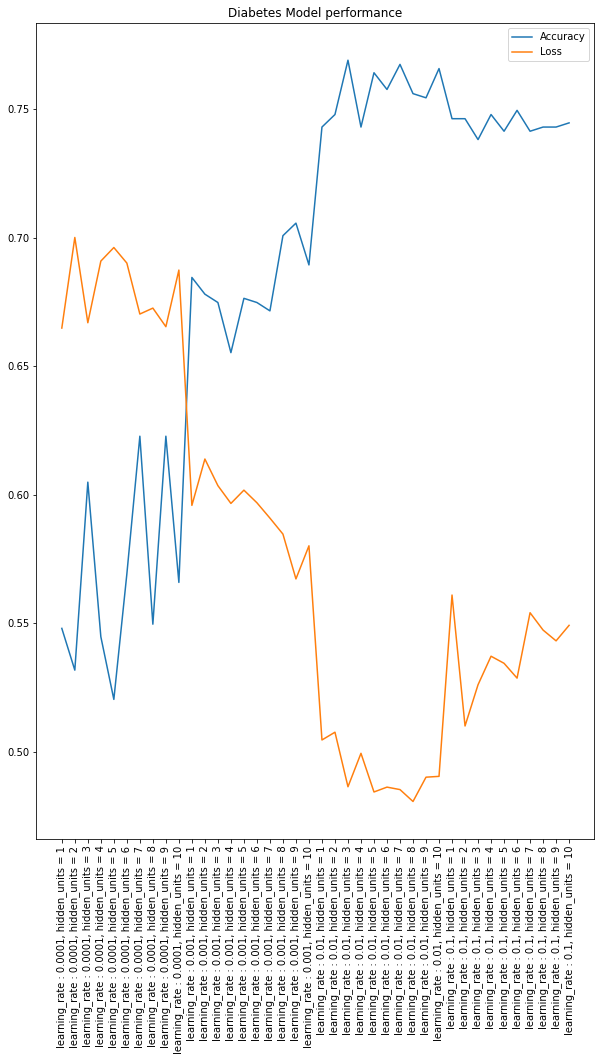

In [35]:
fig,ax = plt.subplots(1,1,figsize = (10,15))

sns.lineplot(results_key,accuracy_values_diabetes,ax = ax,palette = 'b', label = 'Accuracy')
sns.lineplot(results_key,loss_values_diabetes,ax = ax, palette=['r'],label = "Loss")
ax.set_title('Diabetes Model performance')
ax.legend()
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.xticks(rotation = 90)

In [37]:
#combining all the results together for diabetes
overall_results_diabetes = zip(results_key,accuracy_values_diabetes,loss_values_diabetes)
best_model_diabetes = sorted(overall_results_diabetes,key = lambda x : x[1], reverse=True)
best_model_diabetes[0]

('learning_rate : 0.01, hidden_units = 3',
 0.7691056910569106,
 0.4863214916969854)

In [51]:
#Training the best model on the entire training data set and testing on test set with the best parameters found in cross validation
model_diabetes_final = NeuralNetwork(input_shape=train_data_diabetes.shape[1],number_of_hidden_units=3)
loss_fn = nn.BCELoss()
ds_train = TensorDataset(torch.tensor(train_data_diabetes),torch.tensor(train_labels_diabetes))
train_dataloader = DataLoader(ds_train,batch_sampler=None,batch_size=None)
#as we dont do any validation, the validation dataset parameter is None here
model_diabetes_final = train_and_validate(train_dataloader,None,model_diabetes_final,loss_fn,0.01,device,epoch_num,test = True)

#diabetes
test_data_diabetes_scaled = scaler_diabetes.transform(test_data_diabetes)
ds_test = TensorDataset(torch.tensor(test_data_diabetes_scaled),torch.tensor(test_labels_diabetes))
test_dataloader = DataLoader(ds_test,batch_sampler=None,batch_size=None)

loss_fn = nn.BCELoss()
accuracy,loss,y_test_scores,y_predicted = validate(test_dataloader,model_diabetes_final,loss_fn,device,test = True)

In [52]:
print(f"Test Accuracy :{accuracy}, Test Loss {loss}")

Test Accuracy :0.7647058823529411, Test Loss 0.4889199967143047


In [53]:
y_test_scores_array_diabetes = np.array([i.item() for i in y_test_scores])

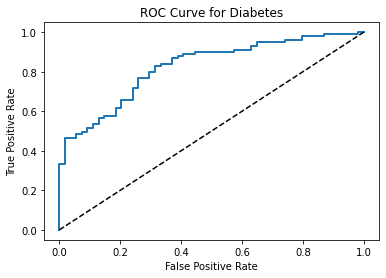

In [54]:
def plot_roc_curve(fpr, tpr,label=None):
 plt.plot(fpr, tpr, linewidth=2, label=label)
 plt.plot([0, 1], [0, 1], 'k--') 
 plt.ylabel('True Positive Rate')
 plt.xlabel('False Positive Rate')
 plt.title('ROC Curve for Diabetes')

fpr_diabetes,tpr_diabetes,threshold_diabetes = roc_curve(test_labels_diabetes,y_test_scores_array_diabetes)
plot_roc_curve(fpr_diabetes, tpr_diabetes)
plt.show()

In [55]:
roc_auc_score_diabetes = roc_auc_score(test_labels_diabetes,y_test_scores_array_diabetes)
roc_auc_score_diabetes

0.8232323232323232

In [56]:
confusion_matrix(test_labels_diabetes,np.round(y_test_scores_array_diabetes))

array([[34, 20],
       [16, 83]], dtype=int64)

<h1> Investigating the Iris dataset </h1>

In [44]:
from itertools import product
learning_rate_list = [1e-4,1e-3,1e-2,0.1]
hidden_units = [1,2,3,4,5,6,7,8,9,10]

combinations = list(product([i for i,j in enumerate(learning_rate_list)], [i for i,j in enumerate(hidden_units)]))
parameter_list = list()

for combination in combinations:
    parameter_list.append([learning_rate_list[combination[0]],hidden_units[combination[1]]])

In [45]:
#diabetes dataset
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
result_dict_iris = dict()
randstate = 1
#go through the parameter combinations, returning the average accuracy and loss 
#on the validation set for each parameter combination
for parameter_set in parameter_list:
    learning_rate = parameter_set[0]
    hidden_units = parameter_set[1]
    epoch_num = 10
    k = 5
    #kfold splitter
    ksplitter = KFold(n_splits = 5, shuffle=True,random_state=42)
    #creating random splits of 80%,20% to create training data and validation data for cross validation. random state is changed for each parameter_set
    model_score = 0
    model_loss = 0
    for train_idx,valid_idx in ksplitter.split(train_data_iris):
        model_iris = NeuralNetwork(input_shape=train_data_iris.shape[1],number_of_hidden_units=hidden_units)
        loss_fn = nn.BCELoss()
        X_train,y_train = train_data_iris[train_idx],train_labels_iris[train_idx]
        X_valid,y_valid = train_data_iris[valid_idx],train_labels_iris[valid_idx]
        #create pytorch dataset
        ds_train = TensorDataset(torch.tensor(X_train),torch.tensor(y_train))
        train_dataloader = DataLoader(ds_train,batch_sampler=None,batch_size=None)
        #iris
        ds_valid = TensorDataset(torch.tensor(X_valid),torch.tensor(y_valid))
        valid_dataloader = DataLoader(ds_valid,batch_sampler=None,batch_size=None)
        model_iris,accuracy,loss = train_and_validate(train_dataloader,valid_dataloader,model_iris,loss_fn,learning_rate,device,epoch_num)
        model_score += accuracy
        model_loss += loss

    result_dict_iris[f'learning_rate : {learning_rate}, hidden_units = {hidden_units}'] = [model_score/k,model_loss/k]

In [47]:
results_key = list()
accuracy_values_iris = list()
loss_values_iris = list()

for i in result_dict_iris:
    results_key.append(i)
    accuracy_values_iris.append(result_dict_iris[i][0])
    loss_values_iris.append(result_dict_iris[i][1])

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

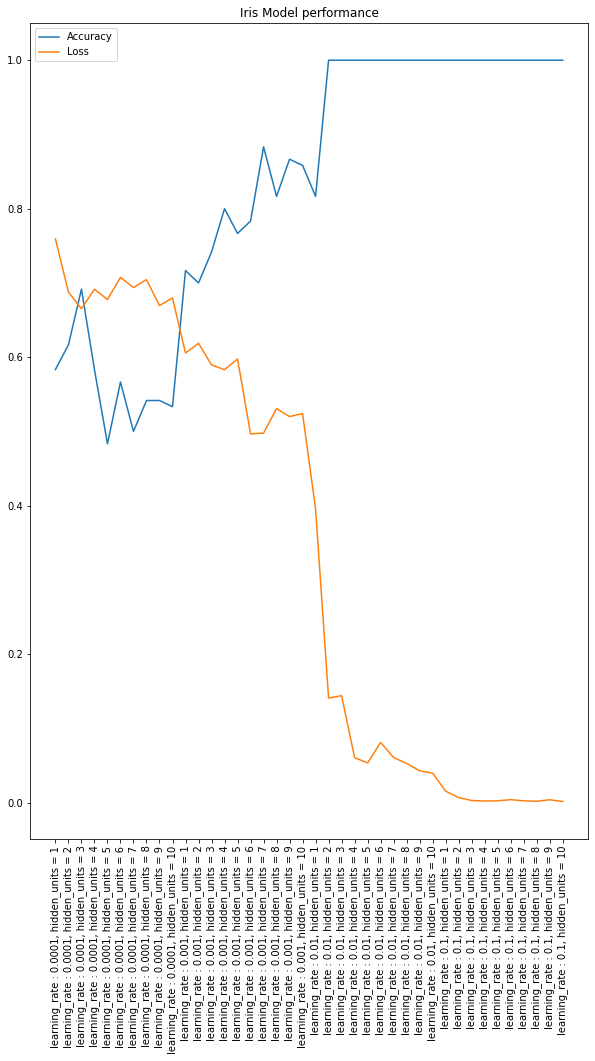

In [48]:
fig,ax = plt.subplots(1,1,figsize = (10,15))

sns.lineplot(results_key,accuracy_values_iris,ax = ax,palette = 'b', label = 'Accuracy')
sns.lineplot(results_key,loss_values_iris,ax = ax, palette='r',label = "Loss")
ax.set_title('Iris Model performance')
ax.legend()
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.xticks(rotation = 90)

In [50]:
#combining all the results together for iris
overall_results_iris = zip(results_key,accuracy_values_iris,loss_values_iris)
best_model_iris = sorted(overall_results_iris,key = lambda x : x[1], reverse=True)
#the top models all have accuracy of 1 on the validation set. Hence we filter it by loss
sorted(best_model_iris, key = lambda x: x[2])[0]


('learning_rate : 0.1, hidden_units = 10', 1.0, 0.0016006947183655029)

In [60]:
#Training the best model on the entire training data set and testing on test set with the best parameters found in cross validation
model_iris_final = NeuralNetwork(input_shape=train_data_iris.shape[1],number_of_hidden_units=10)
loss_fn = nn.BCELoss()
ds_train = TensorDataset(torch.tensor(train_data_iris),torch.tensor(train_labels_iris))
train_dataloader = DataLoader(ds_train,batch_sampler=None,batch_size=None)
#as we dont do any validation, the validation dataset parameter is None here
model_iris_final = train_and_validate(train_dataloader,None,model_iris_final,loss_fn,0.1,device,epoch_num,test = True)

#diabetes
test_data_iris_scaled = scaler_iris.transform(test_data_iris)
ds_test = TensorDataset(torch.tensor(test_data_iris_scaled),torch.tensor(test_labels_iris))
test_dataloader = DataLoader(ds_test,batch_sampler=None,batch_size=None)

loss_fn = nn.BCELoss()
accuracy,loss,y_test_scores,y_predicted = validate(test_dataloader,model_iris_final,loss_fn,device,test = True)

In [61]:
print(f"Test Accuracy :{accuracy}, Test Loss {loss}")

Test Accuracy :1.0, Test Loss 0.003855611985879174


In [62]:
y_test_scores_array_iris= np.array([i.item() for i in y_test_scores])

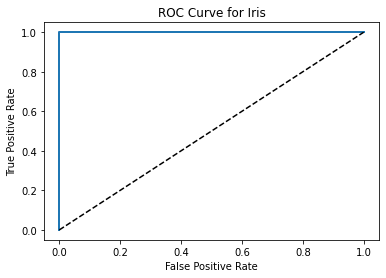

In [63]:
def plot_roc_curve(fpr, tpr,label=None):
 plt.plot(fpr, tpr, linewidth=2, label=label)
 plt.plot([0, 1], [0, 1], 'k--') 
 plt.ylabel('True Positive Rate')
 plt.xlabel('False Positive Rate')
 plt.title('ROC Curve for Iris')

fpr,tpr,threshold = roc_curve(test_labels_iris,y_test_scores_array_iris)
plot_roc_curve(fpr, tpr)
plt.show()

In [64]:
roc_auc_score_iris = roc_auc_score(test_labels_iris,y_test_scores_array_iris)
roc_auc_score_iris

1.0

In [65]:
confusion_matrix(test_labels_iris,np.round(y_test_scores_array_iris))

array([[10,  0],
       [ 0, 20]], dtype=int64)

<h1> Investigating the Wine dataset </h1>

In [66]:
from itertools import product
learning_rate_list = [1e-4,1e-3,1e-2,0.1]
hidden_units = [1,2,3,4,5,6,7,8,9,10]

combinations = list(product([i for i,j in enumerate(learning_rate_list)], [i for i,j in enumerate(hidden_units)]))
parameter_list = list()

for combination in combinations:
    parameter_list.append([learning_rate_list[combination[0]],hidden_units[combination[1]]])

In [71]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
result_dict_wine = dict()
randstate = 1

#go through the parameter combinations, returning the average accuracy and loss 
#on the validation set for each parameter combination
for parameter_set in parameter_list:
    learning_rate = parameter_set[0]
    hidden_units = parameter_set[1]
    epoch_num = 10
    k = 5
    #kfold splitter
    ksplitter = KFold(n_splits = 5, shuffle=True,random_state=42)
    #creating random splits of 80%,20% to create training data and validation data for cross validation
    model_score = 0
    model_loss = 0
    for train_idx,valid_idx in ksplitter.split(train_data_wine):
        model_wine = NeuralNetwork(input_shape=train_data_wine.shape[1],number_of_hidden_units=hidden_units)
        loss_fn = nn.BCELoss()
        X_train,y_train = train_data_wine[train_idx],train_labels_wine[train_idx]
        X_valid,y_valid = train_data_wine[valid_idx],train_labels_wine[valid_idx]
        #create pytorch dataset
        ds_train = TensorDataset(torch.tensor(X_train),torch.tensor(y_train))
        train_dataloader = DataLoader(ds_train,batch_sampler=None,batch_size=None)
        #wine
        ds_valid = TensorDataset(torch.tensor(X_valid),torch.tensor(y_valid))
        valid_dataloader = DataLoader(ds_valid,batch_sampler=None,batch_size=None)
        model_wine,accuracy,loss = train_and_validate(train_dataloader,valid_dataloader,model_wine,loss_fn,learning_rate,device,epoch_num)
        model_score += accuracy
        model_loss += loss
    #average classification accuracy and loss
    result_dict_wine[f'learning_rate : {learning_rate}, hidden_units = {hidden_units}'] = [model_score/k,model_loss/k]

In [72]:
results_key = list()
accuracy_values_wine = list()
loss_values_wine = list()

for i in result_dict_wine:
    results_key.append(i)
    accuracy_values_wine.append(result_dict_wine[i][0])
    loss_values_wine.append(result_dict_wine[i][1])

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

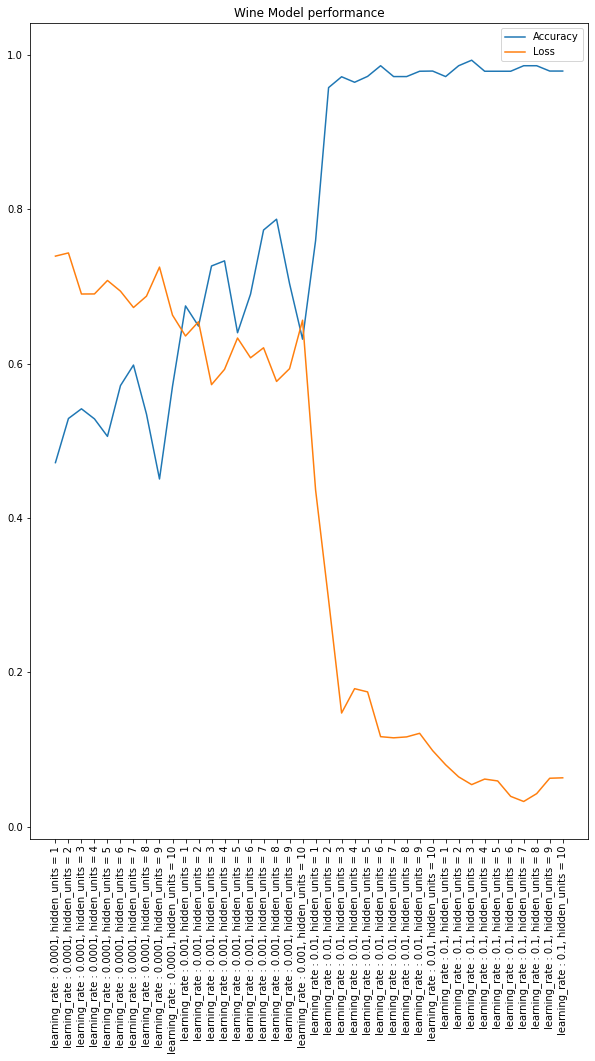

In [74]:
fig,ax = plt.subplots(1,1,figsize = (10,15))

sns.lineplot(results_key,accuracy_values_wine,ax = ax,palette = 'b', label = 'Accuracy')
sns.lineplot(results_key,loss_values_wine,ax = ax, palette='r',label = "Loss")
ax.set_title('Wine Model performance')
ax.legend()
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.xticks(rotation = 90)

In [76]:
#combining all the results together for diabetes
overall_results_wine = zip(results_key,accuracy_values_wine,loss_values_wine)
best_model_wine = sorted(overall_results_wine,key = lambda x : x[1], reverse=True)
best_model_wine[0]

('learning_rate : 0.1, hidden_units = 3',
 0.9928571428571429,
 0.05464936419691572)

In [79]:
#Training the best model on the entire training data set and testing on test set with the best parameters found in cross validation
model_wine_final = NeuralNetwork(input_shape=train_data_wine.shape[1],number_of_hidden_units=3)
loss_fn = nn.BCELoss()
ds_train = TensorDataset(torch.tensor(train_data_wine),torch.tensor(train_labels_wine))
train_dataloader = DataLoader(ds_train,batch_sampler=None,batch_size=None)
#as we dont do any validation, the validation dataset parameter is None here
model_wine_final = train_and_validate(train_dataloader,None,model_wine_final,loss_fn,0.1,device,epoch_num,test = True)

#diabetes
test_data_wine_scaled = scaler_wine.transform(test_data_wine)
ds_test = TensorDataset(torch.tensor(test_data_wine_scaled),torch.tensor(test_labels_wine))
test_dataloader = DataLoader(ds_test,batch_sampler=None,batch_size=None)

loss_fn = nn.BCELoss()
accuracy,loss,y_test_scores,y_predicted = validate(test_dataloader,model_wine_final,loss_fn,device,test = True)

In [80]:
print(f"Test Accuracy :{accuracy}, Test Loss {loss}")

Test Accuracy :0.9722222222222222, Test Loss 0.04218988830529705


In [81]:
y_test_scores_array_wine = np.array([i.item() for i in y_test_scores])

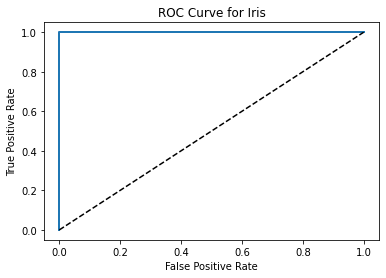

In [82]:
fpr,tpr,threshold = roc_curve(test_labels_wine,y_test_scores_array_wine)
plot_roc_curve(fpr, tpr)
plt.show()

In [92]:
roc_auc_score_wine = roc_auc_score(test_labels_wine,y_test_scores_array_wine)
roc_auc_score_wine

1.0

In [93]:
confusion_matrix(test_labels_wine,np.round(y_test_scores_array_wine))

array([[22,  0],
       [ 1, 13]], dtype=int64)

<h1> Neural Network Models for Multi-Class Datasets </h1>

In [146]:
multi_class_file_path = os.path.join(os.getcwd(),"datasets","multi-class","digits.npz")
multi_class_data = np.load(multi_class_file_path)

In [147]:
multi_class_train_data = multi_class_data["train_X"]
multi_class_train_labels = multi_class_data["train_y"]
multi_class_test_data = multi_class_data["test_X"]
multi_class_test_labels = multi_class_data["test_y"]

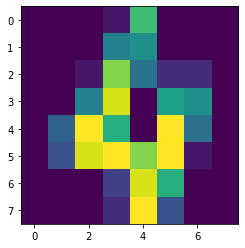

In [148]:
plt.imshow(multi_class_train_data[4].reshape(8,8))

In [149]:
multi_class_train_data.shape

(1437, 64)

We have 1437 training instances, with 64 (8 x 8) pixel intensities. We do not need to flatten the image.

In [150]:
#number of labels 
np.unique(multi_class_train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [151]:
class NeuralNetwork_Multi(nn.Module):
    def __init__(self,input_shape,first_layer_units,second_layer_units):
        super(NeuralNetwork_Multi,self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_stack_multi = nn.Sequential(
            nn.Linear(in_features = input_shape,\
                out_features = first_layer_units,bias=True),
            nn.ReLU(),
            nn.Linear(in_features = first_layer_units,\
                out_features = second_layer_units,bias = True),
            nn.ReLU(),
            #only 10 classes to predict, hence out_features = 10
            nn.Linear(in_features=second_layer_units,out_features=10),
            nn.Softmax()
        )
    def forward(self,X):
        forward_prop = self.linear_stack_multi(X)
        return forward_prop

def train_multi(dataloader,model,loss_fn,optimizer,device):
    model.train()
    for batch,(X,Y) in enumerate(dataloader):
        X = X.to(device)
        Y = Y.to(device)
        y_pred = model(X.float())
        #the cross entropy loss of pytorch works when target is of Long type
        loss = loss_fn(y_pred,Y.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def validate_multi(dataloader,model,loss_fn,device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    correct = 0
    loss_validate = 0
    with torch.no_grad():
        for batch,(X,Y) in enumerate(dataloader):
            X = X.to(device)
            Y = Y.to(device)
            y_pred = model(X.float())
            loss = loss_fn(y_pred,Y.long())
            #whats the loss for one batch
            loss_validate += loss.item()
            #in each batch, how many correct values
            correct += (y_pred.argmax(1) == Y).type(torch.float).sum().item()
    correct = correct/size
    loss_validate = loss_validate/num_batches

    return correct,loss_validate

def train_and_validate_multi(train_dataloader,validate_dataloader,model,loss_fn,learning_rate,device,epoch_no, test = False):
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate)
    #train over multiple epochs
    accuracy_across_all_epochs = 0
    loss_across_all_epochs = 0
    for i in range(epoch_no):
        train_multi(train_dataloader,model,loss_fn,optimizer,device)
    
    if test == True:
        loss_fn = nn.CrossEntropyLoss()
        #here the validate_dataloader variable will be the test set
        avg_accuracy,avg_loss = validate_multi(validate_dataloader,model,loss_fn,device)
        return model,avg_accuracy,avg_loss
    else:
        avg_accuracy,avg_loss = validate_multi(validate_dataloader,model,loss_fn,device)
        return model,avg_accuracy,avg_loss
         

In [152]:
from itertools import product
first_layer_units_list = [15,25,50]
second_layer_units_list = [5,10,20]
learning_rate_list = [0.001,0.01,0.1,0.5]
combinations = list(product([i for i,j in enumerate(first_layer_units_list)], [i for i,j in enumerate(second_layer_units_list)],[i for i,j in enumerate(learning_rate_list)]))
parameter_list = list()

for combination in combinations:
    parameter_list.append([first_layer_units_list[combination[0]],second_layer_units_list[combination[1]],learning_rate_list[combination[2]]])

In [153]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
result_dict_multi = dict()
randstate = 1
#go through the parameter combinations, returning the average accuracy and loss 
#on the validation set for each parameter combination
for parameter_set in parameter_list:
    first_layer_unit_no = parameter_set[0]
    second_layer_unit_no = parameter_set[1]
    learn_rate = parameter_set[2]
    epoch_num = 10
    
    k = 5
    #kfold splitter
    ksplitter = KFold(n_splits = 5, shuffle=True,random_state=42)
    #creating random splits of 80%,20% to create training data and validation data for cross validation
    model_score = 0
    model_loss = 0
    for train_idx,valid_idx in ksplitter.split(train_data_wine):
        model_multi = NeuralNetwork_Multi(input_shape=multi_class_train_data.shape[1],first_layer_units=first_layer_unit_no,second_layer_units=second_layer_unit_no)
        loss_fn = nn.CrossEntropyLoss()
        X_train,y_train = multi_class_train_data[train_idx],multi_class_train_labels[train_idx]
        X_valid,y_valid = multi_class_train_data[valid_idx],multi_class_train_labels[valid_idx]
        #create pytorch dataset
        ds_train = TensorDataset(torch.tensor(X_train),torch.tensor(y_train))
        train_dataloader = DataLoader(ds_train,batch_size=20)
        #multi class
        ds_valid = TensorDataset(torch.tensor(X_valid),torch.tensor(y_valid))
        valid_dataloader = DataLoader(ds_valid,batch_size=10)
        model_multi,accuracy,loss = train_and_validate_multi(train_dataloader,valid_dataloader,model_multi,loss_fn,learn_rate,device,epoch_num)
        model_score += accuracy
        model_loss += loss
    #average classification accuracy and loss
    result_dict_multi[f'learning_rate : {learn_rate}, first layer = {first_layer_unit_no}, second layer = {second_layer_unit_no}'] = [model_score/k,model_loss/k]

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [154]:
results_key = list()
accuracy_values_multi = list()
loss_values_multi = list()

for i in result_dict_multi:
    results_key.append(i)
    accuracy_values_multi.append(result_dict_multi[i][0])
    loss_values_multi.append(result_dict_multi[i][1])

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

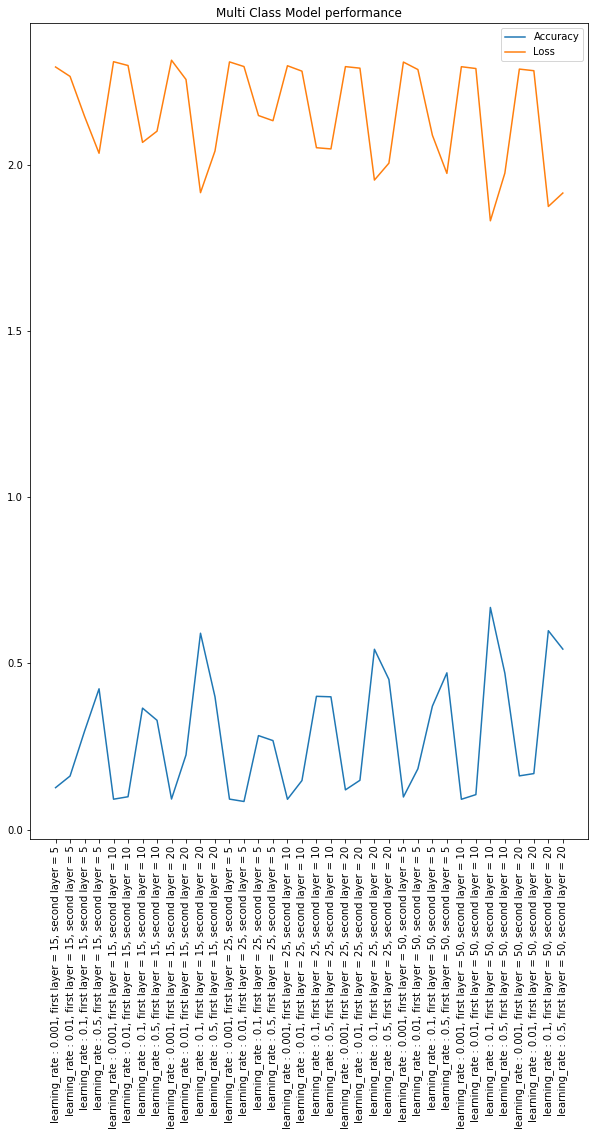

In [155]:
fig,ax = plt.subplots(1,1,figsize = (10,15))

sns.lineplot(results_key,accuracy_values_multi,ax = ax,palette = 'b', label = 'Accuracy')
sns.lineplot(results_key,loss_values_multi,ax = ax, palette='r',label = "Loss")
ax.set_title('Multi Class Model performance')
ax.legend()
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.xticks(rotation = 90)

In [156]:
#combining all the results together for diabetes
overall_results_multi = zip(results_key,accuracy_values_multi,loss_values_multi)
best_model_multi = sorted(overall_results_multi,key = lambda x : x[1], reverse=True)
best_model_multi[0]

('learning_rate : 0.1, first layer = 50, second layer = 10',
 0.6684729064039409,
 1.832144530614217)

In [157]:
model_multi_final = NeuralNetwork_Multi(input_shape=multi_class_train_data.shape[1],first_layer_units=25,second_layer_units=20)
loss_fn = nn.CrossEntropyLoss()
ds_train = TensorDataset(torch.tensor(multi_class_train_data),torch.tensor(multi_class_train_labels))
train_dataloader = DataLoader(ds_train,batch_size=20)
ds_test = TensorDataset(torch.tensor(multi_class_test_data),torch.tensor(multi_class_test_labels))
test_dataloader = DataLoader(ds_test,batch_size=10)

model_multi_final,accuracy_test,loss_test = train_and_validate_multi(train_dataloader,test_dataloader,model_multi_final,loss_fn,0.1,device,epoch_num,test = True)

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [158]:
accuracy_test

0.6666666666666666

<h3> Obtaining the confusion matrix </h3>

In [201]:
predicted = list()
model_multi_final.to(device)
for batch,(X,y) in enumerate(test_dataloader):
    X = X.to(device)
    y = y.to(device)
    y_pred = model_multi_final(X.float())
    predicted.append(y_pred.argmax(1))

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [203]:
predlist = list()
temp = [predlist.extend(i.cpu().detach().tolist()) for i in predicted]

In [206]:
confusion_matrix(multi_class_test_labels,np.array(predlist))

array([[34,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  2,  0,  6,  3,  4, 11,  0, 10],
       [ 0,  0, 34,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0, 14,  0,  0,  4,  0, 14,  0,  5],
       [ 0,  0,  0,  0, 34,  2,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0, 37,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0, 36,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 35,  0,  0],
       [ 2,  0,  5,  0,  2, 18,  1,  1,  0,  4],
       [ 0,  0,  1,  0,  0,  3,  0,  3,  0, 30]], dtype=int64)

In [ ]:
sum([i.size()[0] for i in predicted])

360